Descargado: /content/mes_ensemble_pp_peru.nc
Descargado: /content/prom.pp.clima.nc
Descargado: /content/DEPARTAMENTOS.shp
Descargado: /content/DEPARTAMENTOS.dbf
Descargado: /content/DEPARTAMENTOS.shx
Descargado: /content/SUDA_NUEVO_SIN_PERU_3.shp
Descargado: /content/SUDA_NUEVO_SIN_PERU_3.dbf
Descargado: /content/SUDA_NUEVO_SIN_PERU_3.shx
Gráfico guardado en: /content/graphics/202411/anom_prec_202412.png


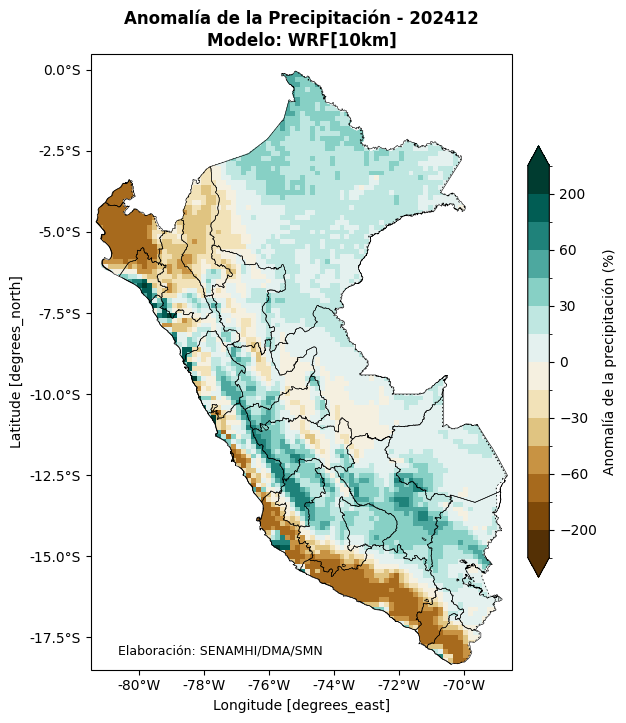

Gráfico guardado en: /content/graphics/202411/anom_prec_202501.png


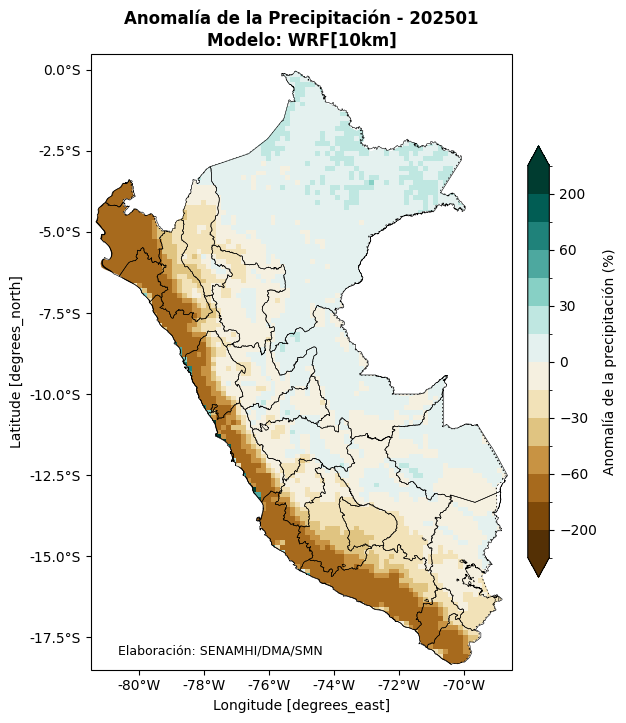

Gráfico guardado en: /content/graphics/202411/anom_prec_202502.png


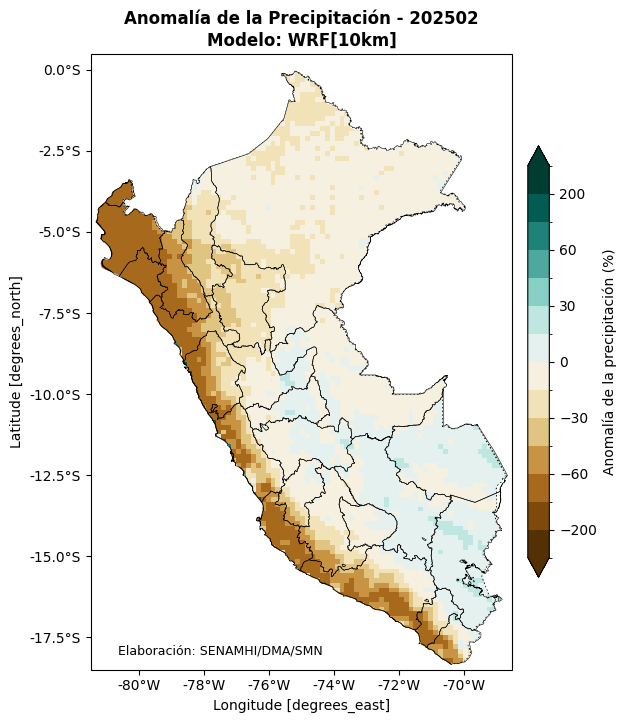

Gráfico guardado en: /content/graphics/202411/anom_prec_202503.png


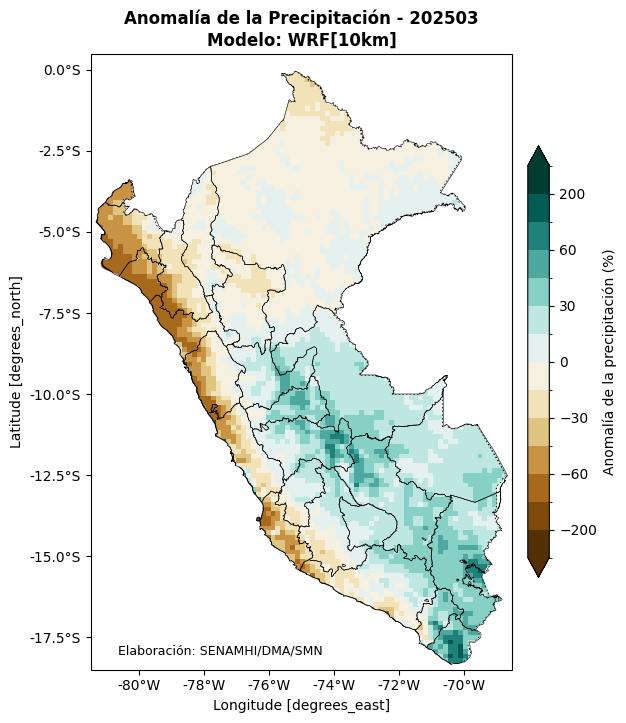

Gráfico guardado en: /content/graphics/202411/anom_prec_202504.png


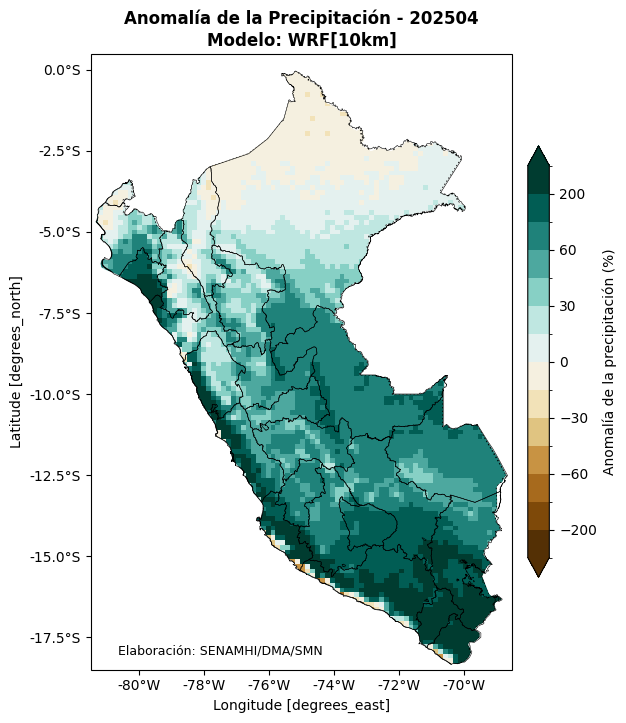

In [14]:
# Instalar librerías necesarias
!pip install geopandas cartopy xarray matplotlib cftime pandas

import os
import requests
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
from matplotlib.colors import BoundaryNorm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import cartopy.feature as cfeature

# Definir año y mes base
base_year = 2024
base_month = 11
base_date_str = f"{base_year}{base_month:02d}"

# Función para añadir meses a una fecha
def add_months_to_date(date, months):
    return date + relativedelta(months=months)

# Descargar archivos desde GitHub
def download_file(url, local_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(local_path, 'wb') as f:
            f.write(response.content)
        print(f"Descargado: {local_path}")
    else:
        print(f"Error al descargar {url}: {response.status_code}")

# Rutas de descarga
files = {
    # NetCDF files
    "archivo_pronostico": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/data/mes_ensemble_pp_peru.nc",
    "archivo_climatologia": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/data/prom.pp.clima.nc",

    # Shapefile de Perú
    "peru_shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shp",
    "peru_dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.dbf",
    "peru_shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shx",

    # Shapefile de Sudamérica sin Perú
    "sudamerica_shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.shp",
    "sudamerica_dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.dbf",
    "sudamerica_shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.shx"
}

local_files = {}
for name, url in files.items():
    local_path = f"/content/{os.path.basename(url)}"
    download_file(url, local_path)
    local_files[name] = local_path

# Verificar que todos los archivos de shapefiles están presentes
def verify_shapefile(base_name):
    for ext in ['.shp', '.dbf', '.shx']:
        if not os.path.exists(base_name + ext):
            raise FileNotFoundError(f"Falta el archivo {base_name + ext}")

verify_shapefile("/content/DEPARTAMENTOS")
verify_shapefile("/content/SUDA_NUEVO_SIN_PERU_3")

# Cargar shapefiles y datos NetCDF
peru = gpd.read_file("/content/DEPARTAMENTOS.shp")
sudamerica = gpd.read_file("/content/SUDA_NUEVO_SIN_PERU_3.shp")
ds_pronostico = xr.open_dataset(local_files["archivo_pronostico"], decode_times=False)
ds_climatologia = xr.open_dataset(local_files["archivo_climatologia"], decode_times=False)

# Verificar y alinear CRS de los shapefiles
if sudamerica.crs != peru.crs:
    sudamerica = sudamerica.to_crs(peru.crs)

# Extraer fecha base del NetCDF
time_units = ds_pronostico['time'].attrs['units']
fecha_base_str = time_units.split('since')[-1].strip()
fecha_base = datetime.strptime(fecha_base_str, "%Y-%m-%d %H:%M:%S")

# Seleccionar variable de precipitación
pronostico_lluvia = ds_pronostico['p']
climatologia_lluvia = ds_climatologia['p']

# Configurar niveles personalizados para anomalías
niveles = np.concatenate([np.arange(-300, -60, 100), np.arange(-60, 61, 15), np.arange(100, 301, 100)])
norm = BoundaryNorm(niveles, ncolors=256)

# Calcular la anomalía y graficar para cada tiempo
output_dir = f"/content/graphics/{base_date_str}"
os.makedirs(output_dir, exist_ok=True)

for i in range(min(len(ds_pronostico.time), len(ds_climatologia.time))):
    # Calcular la fecha real para el tiempo actual
    meses_desde_base = ds_pronostico['time'].isel(time=i).values
    fecha_real = add_months_to_date(fecha_base, int(meses_desde_base))
    fecha_str = f"{fecha_real.year}{fecha_real.month:02d}"

    # Calcular la anomalía porcentual
    pronostico_lluvia_t = pronostico_lluvia.isel(time=i)
    climatologia_lluvia_t = climatologia_lluvia.isel(time=i)
    anomalia_porcentual = ((pronostico_lluvia_t - climatologia_lluvia_t) / climatologia_lluvia_t) * 100

    # Crear el gráfico
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-81.5, -68.5, -18.5, 0.5], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Graficar anomalía
    img = anomalia_porcentual.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', norm=norm, add_colorbar=False)
    cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, extend='both', shrink=0.7, aspect=20)
    cbar.set_label('Anomalía de la precipitación (%)')

    # Añadir shapefiles
    sudamerica.plot(ax=ax, color='white', edgecolor='none', zorder=2)
    peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4, zorder=3)

    # Configurar etiquetas
    ax.set_xticks(np.arange(-80, -68, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-17.5, 2.5, 2.5), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x}°W"))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y}°S"))

    # Añadir texto de elaboración
    ax.text(0.55, 0.02, 'Elaboración: SENAMHI/DMA/SMN',
            horizontalalignment='right', verticalalignment='bottom',
            transform=ax.transAxes, fontsize=9, color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Añadir título y guardar
    plt.title(f"Anomalía de la Precipitación - {fecha_str}\nModelo: WRF[10km]", fontsize=12, fontweight='bold')
    output_path = os.path.join(output_dir, f"anom_prec_{fecha_str}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Gráfico guardado en: {output_path}")
    plt.show()
